This notebooks aims to replicate the experiment from Section 3.1 of the paper "[What can linearized neural networks actually say about generalization?](https://arxiv.org/abs/2106.06770)" on training models on binary eigenfunctions of NTK at initialization as labels.

In [ ]:
!pip install -U -q "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
!pip install -U -q flax neural-tangents chex

In [ ]:
import flax.linen as nn
from flax.core.frozen_dict import freeze
from flax.serialization import to_state_dict, from_state_dict
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
import optax
import chex
import neural_tangents as nt
from scipy.sparse.linalg import eigsh
import numpy as np
import copy
import sys

In [ ]:
class Lenet300_100(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        x = nn.relu(nn.Dense(300)(x))
        x = nn.relu(nn.Dense(100)(x))
        x = nn.Dense(1)(x)
        return x

In [ ]:
key = jax.random.PRNGKey(100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/Paper Implementations/What can linearized neural networks actually say about generalization?/artifacts_mnist_mlp"

In [ ]:
LABEL_IDX = 30
LINEARIZE = False
VERBOSE = False

In [ ]:
data = jnp.load(f'{data_dir}/data.npy', allow_pickle=True)
eig_vecs_init = jnp.load(f'{data_dir}/eig_vecs_init.npy', allow_pickle=True)
print(data.shape, eig_vecs_init.shape)

(20000, 28, 28, 1) (100, 20000)


In [ ]:
def binarize_eigenfunctions(eigen_vec):
    return ((jnp.sign(eigen_vec) + 1) // 2).astype(jnp.float32)

In [ ]:
def get_data(data, eigvecs, label_idx):
    train_ds = {
        "data": data[:18000],
        "labels": binarize_eigenfunctions(eig_vecs_init[label_idx, :18000]),
    }

    test_ds = {
        "data": data[18000:],
        "labels": binarize_eigenfunctions(eig_vecs_init[label_idx, 18000:]),
    }

    return train_ds, test_ds

In [ ]:
model = Lenet300_100()
variables_state_dict = jnp.load(f'{data_dir}/variables_init.npy', allow_pickle=True)[()]
batch = jnp.ones([1, 28, 28, 1])
init_variables = model.init(key, batch)
load_variables = from_state_dict(init_variables, variables_state_dict)

In [ ]:
def get_apply_fn(model, variables, bn=False, train=False):
    if not bn:
        model_state, _ = variables.pop("params")

        def apply_fn(params, x):
            new_vars = freeze({'params': params, **model_state})
            logits = model.apply(new_vars, x, mutable=False)
            return logits
    else:
        def apply_fn(params, x):
            logits = model.apply(params, x, mutable=train)
            return logits

    return apply_fn

In [ ]:
if LINEARIZE:
    model_state, params = load_variables.pop("params")
    original_apply_fn = get_apply_fn(model, load_variables, bn=False, train=False)
    new_apply_fn = nt.linearize(original_apply_fn, params)
    def linear_apply_fn(variables, x, train=True, mutable=False):
        if not train or not mutable:
            return new_apply_fn(variables["params"], x)
        else:
            model_state, params = variables.pop("params")
            return new_apply_fn(params, x), model_state
    apply_fn = linear_apply_fn
else:
    apply_fn = model.apply

In [ ]:
def create_learning_rate_fn(base_learning_rate, steps_per_epoch, num_epochs, lr_schedule="cyclic"):
    if lr_schedule == "linear":

        schedule_fn = optax.linear_schedule(
            init_value=base_learning_rate,
            end_value=0,
            transition_steps=num_epochs * steps_per_epoch,
        )

    elif lr_schedule == "fixed":

        schedule_fn = optax.constant_schedule(value=base_learning_rate)

    elif lr_schedule == "piecewise":
        raise NotImplementedError()

    elif lr_schedule == "cyclic":

        schedule_fn = optax.linear_onecycle_schedule(
            peak_value=base_learning_rate,
            transition_steps=num_epochs * steps_per_epoch,
            pct_start=0.4,
            pct_final=1,
            div_factor=1e8,
            final_div_factor=1e8,
        )

    else:
        raise ValueError("Learning rate error not specified")

    return schedule_fn

@chex.dataclass
class TrainState:
    step: int
    opt_state: optax.OptState
    target: chex.ArrayTree
    model_state: chex.ArrayTree

def create_train_state(
    init_variables,
    optimizer_type,
    learning_rate_fn,
    momentum=None,
):
    """Create initial training state."""
    model_state, params = init_variables.pop("params")
    transforms = []

    if optimizer_type == "sgd":
        transforms += [optax.sgd(learning_rate=learning_rate_fn, momentum=momentum)]
    elif optimizer_type == "adam":
        transforms += [optax.adam(learning_rate=learning_rate_fn)]
    else:
        raise ValueError("Optimizer type not accepted.")

    optimizer = optax.chain(*transforms)
    opt_state = optimizer.init(params)

    state = TrainState(step=0, opt_state=opt_state, target=params, model_state=model_state)
    return state, optimizer

def generate_binary_cross_entropy_loss_fn(apply_fn, state, batch):
    def loss_fn(params):
        variables = make_variables(params, state.model_state)
        logits, new_model_state = apply_fn(variables, batch["data"], mutable=["batch_stats"])
        loss = binary_cross_entropy_loss_with_logits(logits, batch["labels"])
        return loss, (new_model_state, logits)

    return loss_fn

def print_progress(epoch, test_summary, train_summary):
    print(
        "Epoch: %d, train loss: %.4f, train acc.: %.2f%%, test acc.: %.2f%%"
        % (
            epoch,
            train_summary["loss"],
            train_summary["accuracy"] * 100,
            test_summary["accuracy"] * 100,
        )
    )

def split_batch_indices(batch_size, rng, ds):
    ds_size = len(ds["data"])
    if batch_size > 0:
        steps_per_epoch = ds_size // batch_size
    else:
        steps_per_epoch = 1

    if rng is not None:
        indices = jax.random.permutation(rng, ds_size)
    else:
        indices = jnp.arange(ds_size)

    if batch_size > 0:
        indices = indices[: steps_per_epoch * batch_size]  # skip incomplete batch
    indices = indices.reshape((steps_per_epoch, batch_size))
    return indices, steps_per_epoch

def weight_norm(params):
    theta, _ = ravel_pytree(params)
    return jnp.linalg.norm(theta)

def make_variables(params, model_state):
    return freeze({"params": params, **model_state})

def binary_cross_entropy_loss_with_logits(logits, labels):
    return jnp.mean(optax.sigmoid_binary_cross_entropy(logits, labels[:, jnp.newaxis]))

def compute_binary_accuracy_metrics(logits, labels):
    loss = binary_cross_entropy_loss_with_logits(logits, labels)
    predictions = ((jnp.sign(logits) + 1) // 2).astype(float)
    labels_bin = (labels[:, jnp.newaxis] > 0.5).astype(float)
    accuracy = 1 - jnp.abs(predictions - labels_bin).mean()
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics

def create_train_step_fn(
    apply_fn,
    optimizer,
):
    @jax.jit
    def train_step_fn(state, batch, rng_key):

        loss_fn = generate_binary_cross_entropy_loss_fn(apply_fn, state, batch)

        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        aux, grad = grad_fn(state.target)

        new_model_state, logits = aux[1]
        # jax.debug.print(str(len(new_model_state)))
        updates, new_opt_state = optimizer.update(grad, state.opt_state, params=state.target)
        new_target = optax.apply_updates(state.target, updates)

        metrics = compute_binary_accuracy_metrics(logits, batch["labels"])

        metrics["loss_grad_norm"] = jax.device_get(weight_norm(grad))
        metrics["weight_norm"] = jax.device_get(weight_norm(new_target))

        new_state = state.replace(
            step=state.step + 1,
            model_state=new_model_state,
            opt_state=new_opt_state,
            target=new_target,
        )
        return new_state, metrics

    return train_step_fn


def create_eval_model_fn(apply_fn):
    @jax.jit
    def eval_step_fn(state, batch):

        params = state.target
        variables = make_variables(params, state.model_state)
        logits = apply_fn(variables, batch["data"], mutable=False)

        metrics = compute_binary_accuracy_metrics(logits, batch["labels"])

        return metrics

    def eval_model_fn(state, test_ds, batch_size=-1):
        indices, _ = split_batch_indices(batch_size, None, test_ds)
        batch_metrics = []
        for _, perm in enumerate(indices):
            batch = {k: v[perm] for k, v in test_ds.items()}
            metrics = eval_step_fn(state, batch)
            batch_metrics.append(jax.device_get(metrics))

        metrics_np = {
            k: np.mean([metrics[k] for metrics in batch_metrics]) for k in batch_metrics[0]
        }

        return metrics_np

    return eval_model_fn


def sgd_train(
    train_ds,
    test_ds,
    epochs,
    max_lr,
    batch_size,
    lr_schedule,
    momentum,
    apply_fn,
    init_variables,
    key,
    optimizer="sgd",
):
    if VERBOSE:
        print("Initializing optimizer...")

    learning_rate_fn = create_learning_rate_fn(
        base_learning_rate=max_lr,
        num_epochs=epochs,
        steps_per_epoch=len(train_ds["labels"]) // batch_size,
        lr_schedule=lr_schedule,
    )

    init_state, optimizer = create_train_state(
        optimizer_type=optimizer,
        momentum=momentum,
        init_variables=init_variables,
        learning_rate_fn=learning_rate_fn,
    )
    state = copy.deepcopy(init_state)

    train_step_fn = create_train_step_fn(
        apply_fn=apply_fn,
        optimizer=optimizer,
    )
    eval_model_fn = create_eval_model_fn(
        apply_fn=apply_fn,
    )

    if VERBOSE:
        print("Starting training...")
    rng = jax.random.split(key, epochs)

    for epoch in range(epochs):
        perms, steps_per_epoch = split_batch_indices(batch_size, rng[epoch], train_ds)
        for step, perm in enumerate(perms):
            batch = {k: v[perm] for k, v in train_ds.items()}

            state, metrics = train_step_fn(
                state=state, batch=batch, rng_key=jax.random.fold_in(rng[epoch], step)
            )

        train_summary = jax.tree_map(lambda x: jax.device_get(x.mean()), metrics)
        test_summary = eval_model_fn(state, test_ds, batch_size)

        if VERBOSE:
            print_progress(epoch, test_summary, train_summary)

    output_summary = {
        "train": train_summary,
        "test": test_summary,
        "init_state": init_state,
        "end_state": state,
    }

    return output_summary

In [ ]:
key, new_key = jax.random.split(key)

In [ ]:
train_ds, test_ds = get_data(data, eig_vecs_init, LABEL_IDX)

In [ ]:
output_summary = sgd_train(
        train_ds=train_ds,
        test_ds=test_ds,
        apply_fn=apply_fn,
        init_variables=load_variables,
        key=key,
        epochs=50,
        max_lr=0.05,
        lr_schedule="linear",
        momentum=0.9,
        batch_size=128,
        optimizer="sgd"
    )

end_state = output_summary["end_state"]
init_state = output_summary["init_state"]
end_variables = make_variables(end_state.target, end_state.model_state)

print(f"Final test accuracy: {output_summary['test']['accuracy'] * 100} %%")

Final test accuracy: 84.89583134651184 %%


In [ ]:
def params_l2_dist(params1, params2):
    p1, _ = ravel_pytree(params1)
    p2, _ = ravel_pytree(params2)
    return ((p1 - p2) ** 2).sum()

def params_cosine_dist(params1, params2):
    p1, _ = ravel_pytree(params1)
    p2, _ = ravel_pytree(params2)
    inner_prod = jnp.sum(p1 * p2)
    norm1 = jnp.linalg.norm(p1)
    norm2 = jnp.linalg.norm(p2)
    dist = 1 - (inner_prod / (norm1 * norm2))
    return dist

In [ ]:
l2_dist_init = params_l2_dist(init_state.target, end_state.target)
print(f"L2 distance from initialization: {l2_dist_init}")

cosine_dist_init = params_cosine_dist(init_state.target, end_state.target)
print(f"Cosine distance from initialization: {cosine_dist_init}")

L2 distance from initialization: 327.38494873046875
Cosine distance from initialization: 0.22380316257476807


In [ ]:
fin_accuracies = []
for label_id in range(eig_vecs_init.shape[0]):
    train_ds, test_ds = get_data(data, eig_vecs_init, label_id)

    output_summary = sgd_train(
        train_ds=train_ds,
        test_ds=test_ds,
        apply_fn=apply_fn,
        init_variables=load_variables,
        key=key,
        epochs=50,
        max_lr=0.05,
        lr_schedule="linear",
        momentum=0.9,
        batch_size=128,
        optimizer="sgd"
    )

    print(f"Label idx: {label_id} \t Final test accuracy: {output_summary['test']['accuracy'] * 100} %%")
    fin_accuracies.append(output_summary['test']['accuracy'] * 100)

Label idx: 0 	 Final test accuracy: 100.0 %%
Label idx: 1 	 Final test accuracy: 96.45833373069763 %%
Label idx: 2 	 Final test accuracy: 94.9999988079071 %%
Label idx: 3 	 Final test accuracy: 97.23958373069763 %%
Label idx: 4 	 Final test accuracy: 96.82291746139526 %%
Label idx: 5 	 Final test accuracy: 95.20833492279053 %%
Label idx: 6 	 Final test accuracy: 94.47916746139526 %%
Label idx: 7 	 Final test accuracy: 94.8437511920929 %%
Label idx: 8 	 Final test accuracy: 94.63541507720947 %%
Label idx: 9 	 Final test accuracy: 94.0625011920929 %%
Label idx: 10 	 Final test accuracy: 92.81250238418579 %%
Label idx: 11 	 Final test accuracy: 93.33333373069763 %%
Label idx: 12 	 Final test accuracy: 94.37500238418579 %%
Label idx: 13 	 Final test accuracy: 91.97916388511658 %%
Label idx: 14 	 Final test accuracy: 92.55208373069763 %%
Label idx: 15 	 Final test accuracy: 93.85416507720947 %%
Label idx: 16 	 Final test accuracy: 90.46875238418579 %%
Label idx: 17 	 Final test accuracy: 88

In [ ]:
if LINEARIZE:
    jnp.save(f'{data_dir}/linearized_accuracies.npy', fin_accuracies)
else:
    jnp.save(f'{data_dir}/non-linearized_accuracies.npy', fin_accuracies)

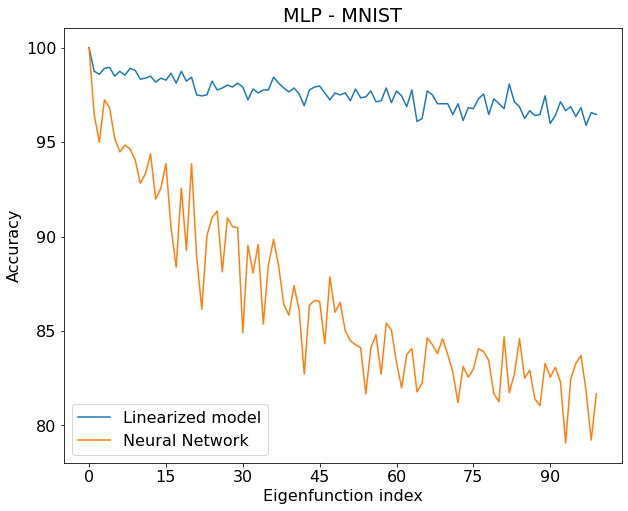

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["font.size"] = 16

linearized_accuracies = jnp.load(f'{data_dir}/linearized_accuracies.npy')
non_linearized_accuracies = jnp.load(f'{data_dir}/non-linearized_accuracies.npy')

assert linearized_accuracies.shape[0] == 100
assert non_linearized_accuracies.shape[0] == 100

tot = linearized_accuracies.shape[0]
fig0, ax0 = plt.subplots(1, 1)
ax0.plot(range(tot), linearized_accuracies, label='Linearized model')
ax0.plot(range(tot), non_linearized_accuracies, label='Neural Network')
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.set_xlabel('Eigenfunction index')
ax0.set_ylabel('Accuracy')
ax0.set_title('MLP - MNIST')
ax0.legend();